In [1]:
import pandas as pd
import random
import math
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier

# Colab 進行matplotlib繪圖時顯示繁體中文
# 下載台北思源黑體並命名taipei_sans_tc_beta.ttf，移至指定路徑
#!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager

# 改style要在改font之前
plt.style.use('seaborn')

fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

In [2]:
def plot_unknown_counts(prob_map, label_names):
    thresholds = [i / 100 for i in range(60, 96, 5)]  # 從0.6到0.95，每隔0.05
    counts = []
    for threshold in thresholds:
        count = 0
        for prob in prob_map:
            if max(prob) < threshold:
                count += 1
        counts.append(count)
    
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, counts, marker='o', linestyle='-')
    plt.title('不同閾值下的Count of Unknown數量')
    plt.xlabel('Threshold')
    plt.ylabel('Count of Unknown')
    plt.grid(True)
    plt.show()

## K-means

1. 隨機給K個群心
2. 算距離分群 - 歐式距離
3. 在分好的群裡面找出新的群心 - sum(x,y) / len
4. 重複2~3
5. return label_list - 0, 1, 2

In [3]:
# 計算歐式距離 Euclidean Distance
def Euclidean_distance(data1, data2):
    total = 0
    for i, _ in enumerate(data1):
        total += ((data1[i] - data2[i]) ** 2)
    return math.sqrt(total)

In [4]:
# Add by 楨君
# 計算最佳k clusters數量 - 運算每個 k 值的 WCSS：對於每個 k 值，運行 K-means，計算並記錄 WCSS。
def calculate_wcss(train_data_list, cluster_list, centroid_list):
    total_wcss = 0
    for idx, train_data in enumerate(train_data_list):
        centroid = centroid_list[cluster_list[idx]]
        total_wcss += Euclidean_distance(train_data, centroid) ** 2
    return total_wcss

In [5]:
# 找到新的群心
def renew_centroid(train_data_list, cluster_list, k_clusters):
    # columns 數目
    num_columns = len(train_data_list[0])
    # 創建一個全為 0 且 [columns * k] 大小的list 
    new_clusters = [[0 for _ in range(num_columns)] for _ in range(k_clusters)]
    # 紀錄各 cluster 的長度
    clusters_len = [0 for _ in range(k_clusters)]

    for idx, cluster in enumerate(cluster_list):
        for i in range(num_columns):
            # 將相同 cluster 且相同 column 的值相加
            new_clusters[cluster][i] += train_data_list[idx][i]
            # 將該 cluster 的長度加 1
        clusters_len[cluster] += 1
    
    # 將每一格除以該 cluster 的數量
    for i, cluster in enumerate(new_clusters):
        for j in range(num_columns):
            new_clusters[i][j] = new_clusters[i][j] / clusters_len[i]

    return new_clusters

In [6]:
# 跑 k-means
# 丟 list 跟 群數進來
def kmeans(train_data_list, k_clusters):

    # 隨機抽 k 個data作為群心
    # center list 存 data 的完整資料
    random.seed(1116)
    centroid_list = [train_data_list[i] for i in random.sample(range(len(train_data_list)), k_clusters)]

    # 紀錄每個data的群心
    cluster_list = []
    iter = 0
    while True:
        print("K-means Iteration:", iter)
        iter += 1
        cluster_list = []
        # 替每個data找到最近的群心
        for train_data in train_data_list:
            # 將data與所有群心的距離存進list中
            dis_list = [Euclidean_distance(train_data, centroid) for centroid in centroid_list]
            # 找到距離最近群心最小值的位置, 並加入cluster_list中
            cluster_list.append(dis_list.index(min(dis_list)))
        
        old_centroid_list = centroid_list
        centroid_list = renew_centroid(train_data_list, cluster_list, k_clusters)
        # 比較新舊群心有沒有差
        if old_centroid_list == centroid_list: 
            break
    
    return cluster_list, centroid_list  # 返回群集列表和中心點列表

In [7]:
# Add by 楨君
def elbow_method(train_data_list, max_k):
    wcss_values = []
    for k in range(1, max_k+1):
        print(f"Testing k = {k}")
        cluster_list, centroid_list = kmeans(train_data_list, k)
        wcss = calculate_wcss(train_data_list, cluster_list, centroid_list)
        wcss_values.append(wcss)
    
    # 繪製肘部圖
    plt.figure(figsize=(8, 4))
    # plt.plot(range(1, max_k+1), wcss_values, marker='o')
    #從第二筆資料開始
    wcss_values.pop(0)
    plt.plot(range(2, max_k+1), wcss_values, marker='o')
    
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('WCSS')
    plt.title('Elbow Method for Determining Optimal k')
    plt.show()

In [8]:
# 準備跑 k-means 前的處理
def run_cluster(unknown_test_data):
    # 將資料轉成 list
    train_data_list = unknown_test_data.values.tolist()
    # cluster 數量
    '''找到最佳的 k 個群集數量來執行 K-means 聚類分析，可以使用「肘部法則」(Elbow Method)。
    這個方法通過評估不同 k 值對應的聚類成本（例如，所有點到其對應群集中心的距離平方和，
    稱為 WCSS：Within-Cluster Sum of Squares）來選擇最佳的 k 值。當 WCSS 的下降速度明顯減緩時，該 k 值可能是一個好的選擇。'''
    elbow_method(train_data_list, 10) #找最佳cluster數量 ,max設置為10 (再多會跑超久)
    k_clusters = 9
    cluster_list, centroid_list  = kmeans(train_data_list, k_clusters)# 返回群集列表和中心點列表 
    
    return cluster_list

In [9]:
# 找到每個 cluster 所代表的類別
def find_cluster_class(predict_cluster, unknown_indices, test_label, label_names):
    # 找出 test data 中所有 label
    labels = [i for i in test_label["Class"].unique()]
    test_label_list = test_label.values.tolist()
    # 找出有幾個 cluster
    k_clusters = pd.DataFrame(predict_cluster, columns=["cluster"])["cluster"].unique().shape[0]
    
    # 創建一個包含 dict 的 list，類似長這樣
    # [{'KIRC': 0, 'BRCA': 0, 'LUAD': 0}, {'KIRC': 0, 'BRCA': 0, 'LUAD': 0}, {'KIRC': 0, 'BRCA': 0, 'LUAD': 0}]
    result = [{label:0 for label in labels} for _ in range(k_clusters)]


    # 紀錄各 cluster 中，不同 label 數量
    for idx, kmeans in enumerate(predict_cluster):
        result[kmeans][test_label_list[idx][0]] += 1
        
    # 創建一個新的列表，其中不包含 label_names 中的鍵
    filtered_result = [{key: value for key, value in d.items() if key not in label_names} for d in result]

    # 取每一 cluster 中最常見的 label，當作整群的label
    cluster_label = {idx:max(i, key=i.get) for idx, i in enumerate(filtered_result)}

    # 回傳每個 cluster 代表的 label
    return cluster_label
    

In [10]:
# 幫 unknown 類別分群
def unknown_cluster(predict_classification, test_data, test_label, label_names):

    # 每個 data 的 類別
    predict_classification_df = pd.DataFrame(predict_classification, columns=["index", "class"])
    unknowns = predict_classification_df[predict_classification_df["class"] == "unknown"]

    # 找到 unknown 類別的位置
    unknown_indices = unknowns["index"].values
    # 將 test data 中的 unknown data 取出
    unknown_test_data = test_data.loc[unknown_indices]

    # 將 unknown data 丟去跑分群，回傳每個 unknown data 的分群類別
    # [3, 6, 7, 3, 6, 6, 3, 3, 5, 6, 3, 3, 3, 3....]
    cluster_result = run_cluster(unknown_test_data)

    # 將 unknown 類別的 index 轉為 list
    unknown_indices = unknown_indices.tolist()
    # 找到每個 cluster 所代表的類別，回傳一個 dict
    # {0: 'PRAD', 1: 'PRAD', 2: 'PRAD', 3: 'COAD', 4: 'PRAD', 5: 'PRAD', 6: 'PRAD', 7: 'PRAD', 8: 'PRAD'}
    cluster_label = find_cluster_class(cluster_result, unknown_indices, test_label, label_names)
    
    # 依據 dict，將 cluster 由數字替換成類別
    new_cluster_result = [cluster_label[i] for i in cluster_result]

    # 只取 class 的 list
    predict_list = predict_classification_df.drop(columns=['index']).values.tolist()
    predict_list = [i[1] for i in predict_classification]
    
    # 將 predict_list 中 unknown 的部份替換為新的類別
    # i 為 第幾個 unknown, idx 為 unknown 在全部 data 中的位置
    for i, idx in enumerate(unknown_indices):
        predict_list[idx] = new_cluster_result[i]

    # 回傳新的 predict list
    return predict_list


In [11]:
# 將 data 分成原本的類別以及 unknown 類別
def predict_label(prob_map, label_names):
    # prob 小於 threshold 判斷為 unknown
    threshold = 0.85
    count = 0 #計算有多少小於threshold的資料
    prob_map = prob_map.tolist()
    predict_list = []
    # 將 index 以及類別加入 predict_list 中
    for idx, prob in enumerate(prob_map):
        max_val = max(prob)
        if max_val < threshold:
            predict_list.append([idx, "unknown"])
            count+=1
        else:
            predict_list.append([idx, label_names[prob.index(max_val)]])
    print('predict_label閥值設定為:',threshold,'有',count,'筆資料屬於unknown')
    return predict_list


In [12]:
def predict_acc(predict_classification, test_label):
    test_label_list = [i[0] for i in test_label.values.tolist()]
    total = len(predict_classification)
    sum = 0
    for i, predict in enumerate(predict_classification):
        if predict == test_label_list[i]:
            sum += 1
    return sum / total
    

In [13]:
# 丟 dataframe 進去
def random_forest(train_data, train_label, test_data, test_label):
    # 創建隨機森林模型 (使用預設參數)
    clf = RandomForestClassifier(random_state=1116)
    clf.fit(train_data, train_label)

    # 進行預測，回傳每個 label 的機率
    prob_map = clf.predict_proba(test_data)
    label_names = clf.classes_
    
    #繪製圖，方便判斷閥值要設多少
    plot_unknown_counts(prob_map, label_names)
    
    # 判斷類別，分成訓練資料的類別 + unknown 類別
    predict_classification = predict_label(prob_map, label_names)

    # 幫每個 unknown 分群，並且回傳新的 predict
    final_predict_list = unknown_cluster(predict_classification, test_data, test_label, label_names)
    
    # 計算準確率
    acc = predict_acc(final_predict_list, test_label)
    print("accuracy", acc)  


### 資料前處理

In [14]:
# 改成直接讀取 dataframe
def data_preprocessing(train_data_path):
    # 檢查有無缺失值
    # train_data = pd.read_csv(train_data_path)
    train_data = train_data_path
    missing_data = check_missing_data(train_data)
    total_missing = missing_data.sum()
    print(f"Total missing values: {total_missing}")

    # 檢查與處理異常值
    train_data = handle_outliers(train_data)

    return train_data

# 檢查有幾個缺失值
def check_missing_data(data):
    return data.isnull().sum()

# 檢查異常值
# 使用 IQR 方式偵測異常值
def detect_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = (data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))
    return outliers

# 處理異常值
# 平均數填補異常值
def handle_outliers(data):
    outliers = detect_outliers(data)
    for column in data.columns:
        data.loc[outliers[column], column] = data[column].mean()
    return data

### 原本資料集

Total missing values: 0


C:\Users\win90\AppData\Local\Temp\ipykernel_11272\814722227.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(train_data, train_label)


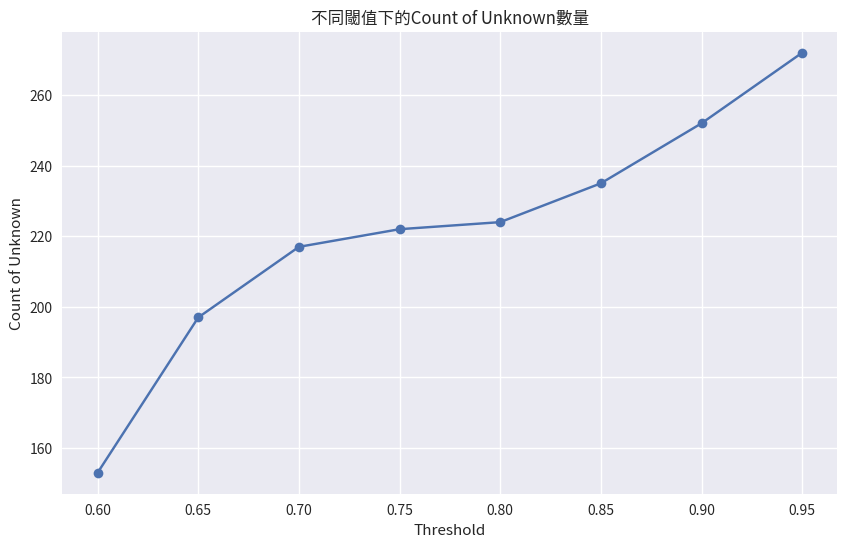

predict_label閥值設定為: 0.85 有 235 筆資料屬於unknown
Testing k = 1
K-means Iteration: 0
K-means Iteration: 1
Testing k = 2
K-means Iteration: 0
K-means Iteration: 1
K-means Iteration: 2
Testing k = 3
K-means Iteration: 0
K-means Iteration: 1
K-means Iteration: 2
K-means Iteration: 3
K-means Iteration: 4
K-means Iteration: 5
K-means Iteration: 6
K-means Iteration: 7
Testing k = 4
K-means Iteration: 0
K-means Iteration: 1
K-means Iteration: 2
K-means Iteration: 3
K-means Iteration: 4
K-means Iteration: 5
K-means Iteration: 6
K-means Iteration: 7
Testing k = 5
K-means Iteration: 0
K-means Iteration: 1
K-means Iteration: 2
K-means Iteration: 3
K-means Iteration: 4
K-means Iteration: 5
K-means Iteration: 6
K-means Iteration: 7
Testing k = 6
K-means Iteration: 0
K-means Iteration: 1
K-means Iteration: 2
K-means Iteration: 3
K-means Iteration: 4
K-means Iteration: 5
K-means Iteration: 6
K-means Iteration: 7
K-means Iteration: 8
Testing k = 7
K-means Iteration: 0
K-means Iteration: 1
K-means Iteration:

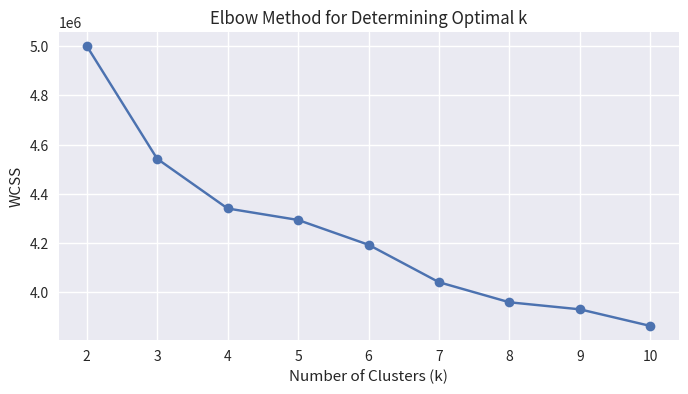

K-means Iteration: 0
K-means Iteration: 1
K-means Iteration: 2
K-means Iteration: 3
K-means Iteration: 4
K-means Iteration: 5
K-means Iteration: 6
K-means Iteration: 7
K-means Iteration: 8
K-means Iteration: 9
K-means Iteration: 10
K-means Iteration: 11
K-means Iteration: 12
K-means Iteration: 13
K-means Iteration: 14
K-means Iteration: 15
K-means Iteration: 16
K-means Iteration: 17
accuracy 0.7981927710843374


In [46]:
# 讀取資料集
train_data = pd.read_csv("dataset/gene expression cancer RNA-Seq Data Set/train_data.csv")
train_label = pd.read_csv("dataset/gene expression cancer RNA-Seq Data Set/train_label.csv")
test_data = pd.read_csv("dataset/gene expression cancer RNA-Seq Data Set/test_data.csv")
test_label = pd.read_csv("dataset/gene expression cancer RNA-Seq Data Set/test_label.csv")

# 處理資料集
train_data = train_data.drop(columns="id")
train_label = train_label.drop(columns="id")
test_data = test_data.drop(columns="id")
test_label = test_label.drop(columns="id")

# 資料前處理
train_data = data_preprocessing(train_data)
# 丟 dataframe 進去
random_forest(train_data, train_label, test_data, test_label)

## 以下分別用四種不同資料擴增跑的結果

### SMOTE

Total missing values: 0


C:\Users\win90\AppData\Local\Temp\ipykernel_11272\814722227.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(train_data, train_label)


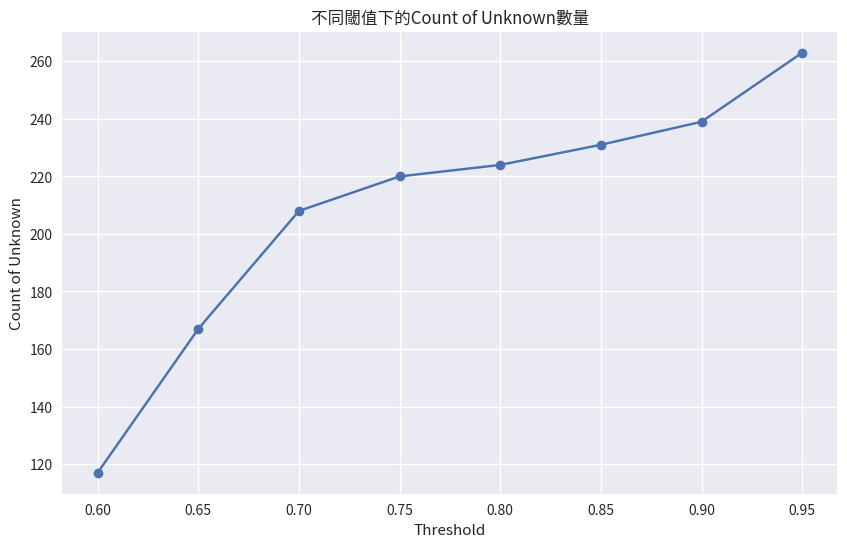

predict_label閥值設定為: 0.85 有 231 筆資料屬於unknown
Testing k = 1
K-means Iteration: 0
K-means Iteration: 1
Testing k = 2
K-means Iteration: 0
K-means Iteration: 1
K-means Iteration: 2
K-means Iteration: 3
K-means Iteration: 4
Testing k = 3
K-means Iteration: 0
K-means Iteration: 1
K-means Iteration: 2
K-means Iteration: 3
K-means Iteration: 4
Testing k = 4
K-means Iteration: 0
K-means Iteration: 1
K-means Iteration: 2
K-means Iteration: 3
K-means Iteration: 4
K-means Iteration: 5
K-means Iteration: 6
K-means Iteration: 7
K-means Iteration: 8
K-means Iteration: 9
K-means Iteration: 10
K-means Iteration: 11
Testing k = 5
K-means Iteration: 0
K-means Iteration: 1
K-means Iteration: 2
K-means Iteration: 3
K-means Iteration: 4
K-means Iteration: 5
K-means Iteration: 6
K-means Iteration: 7
K-means Iteration: 8
K-means Iteration: 9
Testing k = 6
K-means Iteration: 0
K-means Iteration: 1
K-means Iteration: 2
K-means Iteration: 3
K-means Iteration: 4
K-means Iteration: 5
K-means Iteration: 6
K-means I

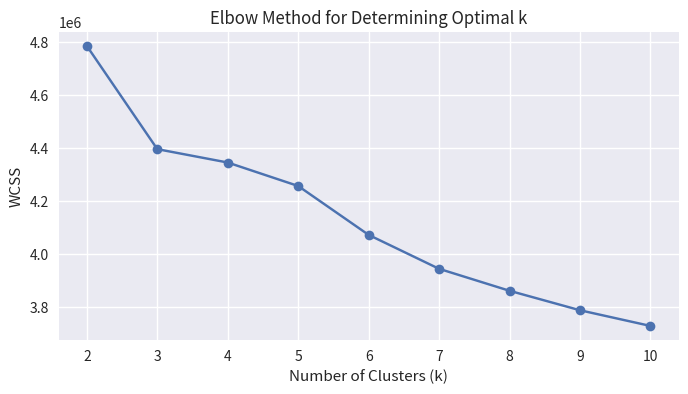

K-means Iteration: 0
K-means Iteration: 1
K-means Iteration: 2
K-means Iteration: 3
K-means Iteration: 4
K-means Iteration: 5
K-means Iteration: 6
K-means Iteration: 7
K-means Iteration: 8
accuracy 0.713855421686747


In [64]:
# SMOTE 資料
train_path = "dataset/gene expression cancer RNA-Seq Data Set/resampled_train_data_SMOTE.csv"
train_label_path = "dataset/gene expression cancer RNA-Seq Data Set/resampled_train_label_SMOTE.csv"
test_path = "dataset/gene expression cancer RNA-Seq Data Set/test_data.csv"
test_label_path = "dataset/gene expression cancer RNA-Seq Data Set/test_label.csv"

# 讀取資料集
train_data = pd.read_csv(train_path)
train_label = pd.read_csv(train_label_path)
test_data = pd.read_csv(test_path)
test_label = pd.read_csv(test_label_path)

test_data = test_data.drop(columns="id")
test_label = test_label.drop(columns="id")

# 資料前處理
train_data = data_preprocessing(train_data)
# 丟 dataframe 進去
random_forest(train_data, train_label, test_data, test_label)

### bSMOTE

Total missing values: 0


C:\Users\win90\AppData\Local\Temp\ipykernel_11272\814722227.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(train_data, train_label)


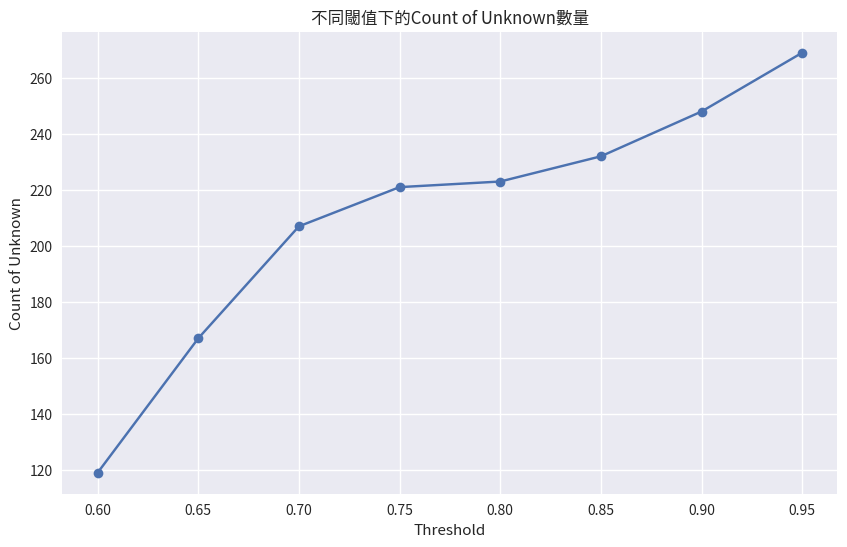

predict_label閥值設定為: 0.85 有 232 筆資料屬於unknown
Testing k = 1
K-means Iteration: 0
K-means Iteration: 1
Testing k = 2
K-means Iteration: 0
K-means Iteration: 1
K-means Iteration: 2
K-means Iteration: 3
Testing k = 3
K-means Iteration: 0
K-means Iteration: 1
K-means Iteration: 2
K-means Iteration: 3
K-means Iteration: 4
K-means Iteration: 5
K-means Iteration: 6
K-means Iteration: 7
K-means Iteration: 8
K-means Iteration: 9
K-means Iteration: 10
K-means Iteration: 11
K-means Iteration: 12
Testing k = 4
K-means Iteration: 0
K-means Iteration: 1
K-means Iteration: 2
K-means Iteration: 3
K-means Iteration: 4
K-means Iteration: 5
K-means Iteration: 6
K-means Iteration: 7
K-means Iteration: 8
K-means Iteration: 9
K-means Iteration: 10
Testing k = 5
K-means Iteration: 0
K-means Iteration: 1
K-means Iteration: 2
K-means Iteration: 3
K-means Iteration: 4
K-means Iteration: 5
K-means Iteration: 6
K-means Iteration: 7
K-means Iteration: 8
Testing k = 6
K-means Iteration: 0
K-means Iteration: 1
K-means

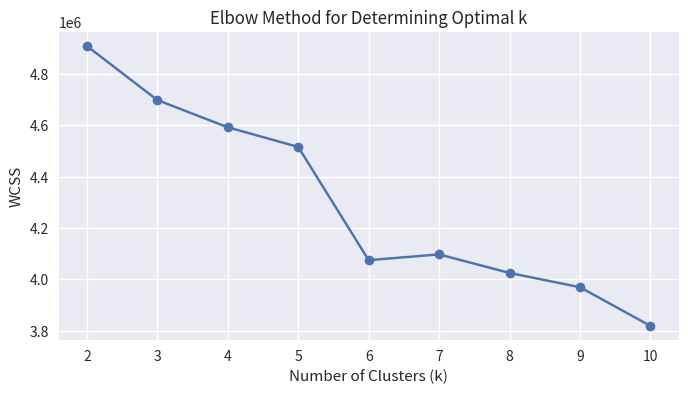

K-means Iteration: 0
K-means Iteration: 1
K-means Iteration: 2
K-means Iteration: 3
K-means Iteration: 4
K-means Iteration: 5
K-means Iteration: 6
K-means Iteration: 7
K-means Iteration: 8
K-means Iteration: 9
K-means Iteration: 10
accuracy 0.7108433734939759


In [65]:
# bSMOTE 資料
train_path = "dataset/gene expression cancer RNA-Seq Data Set/resampled_train_data_bSMOTE.csv"
train_label_path = "dataset/gene expression cancer RNA-Seq Data Set/resampled_train_label_bSMOTE.csv"
test_path = "dataset/gene expression cancer RNA-Seq Data Set/test_data.csv"
test_label_path = "dataset/gene expression cancer RNA-Seq Data Set/test_label.csv"

# 讀取資料集
train_data = pd.read_csv(train_path)
train_label = pd.read_csv(train_label_path)
test_data = pd.read_csv(test_path)
test_label = pd.read_csv(test_label_path)

test_data = test_data.drop(columns="id")
test_label = test_label.drop(columns="id")

# 資料前處理
train_data = data_preprocessing(train_data)
# 丟 dataframe 進去
random_forest(train_data, train_label, test_data, test_label)

### RandomOverSampler

Total missing values: 0


C:\Users\win90\AppData\Local\Temp\ipykernel_11272\814722227.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(train_data, train_label)


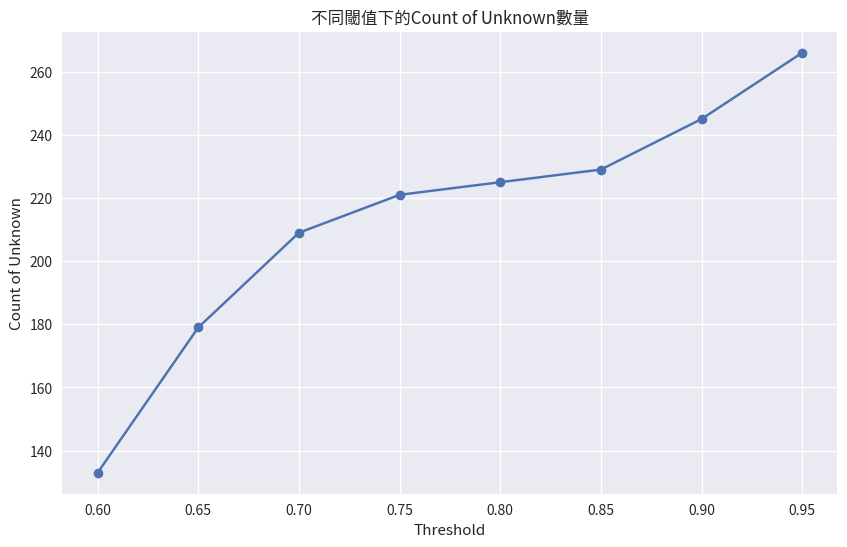

predict_label閥值設定為: 0.85 有 229 筆資料屬於unknown
Testing k = 1
K-means Iteration: 0
K-means Iteration: 1
Testing k = 2
K-means Iteration: 0
K-means Iteration: 1
K-means Iteration: 2
K-means Iteration: 3
K-means Iteration: 4
Testing k = 3
K-means Iteration: 0
K-means Iteration: 1
K-means Iteration: 2
K-means Iteration: 3
K-means Iteration: 4
K-means Iteration: 5
K-means Iteration: 6
Testing k = 4
K-means Iteration: 0
K-means Iteration: 1
K-means Iteration: 2
K-means Iteration: 3
K-means Iteration: 4
K-means Iteration: 5
K-means Iteration: 6
K-means Iteration: 7
K-means Iteration: 8
Testing k = 5
K-means Iteration: 0
K-means Iteration: 1
K-means Iteration: 2
K-means Iteration: 3
K-means Iteration: 4
K-means Iteration: 5
K-means Iteration: 6
K-means Iteration: 7
K-means Iteration: 8
Testing k = 6
K-means Iteration: 0
K-means Iteration: 1
K-means Iteration: 2
K-means Iteration: 3
K-means Iteration: 4
Testing k = 7
K-means Iteration: 0
K-means Iteration: 1
K-means Iteration: 2
K-means Iteration:

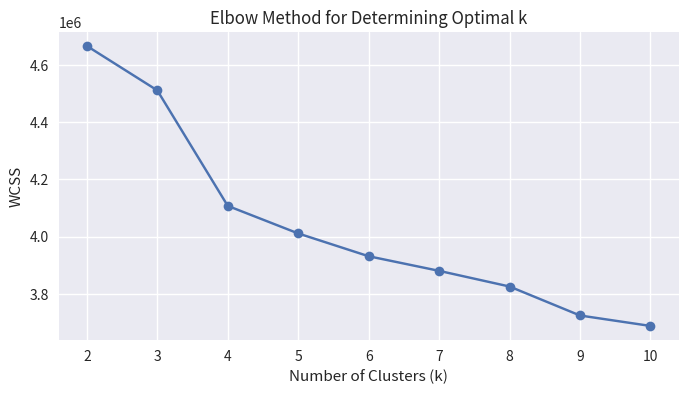

K-means Iteration: 0
K-means Iteration: 1
K-means Iteration: 2
K-means Iteration: 3
K-means Iteration: 4
K-means Iteration: 5
K-means Iteration: 6
accuracy 0.608433734939759


In [66]:
# RandomOverSampler 資料
train_path = "dataset/gene expression cancer RNA-Seq Data Set/resampled_train_data_ROS.csv"
train_label_path = "dataset/gene expression cancer RNA-Seq Data Set/resampled_train_label_ROS.csv"
test_path = "dataset/gene expression cancer RNA-Seq Data Set/test_data.csv"
test_label_path = "dataset/gene expression cancer RNA-Seq Data Set/test_label.csv"

# 讀取資料集
train_data = pd.read_csv(train_path)
train_label = pd.read_csv(train_label_path)
test_data = pd.read_csv(test_path)
test_label = pd.read_csv(test_label_path)

test_data = test_data.drop(columns="id")
test_label = test_label.drop(columns="id")

# 資料前處理
train_data = data_preprocessing(train_data)
# 丟 dataframe 進去
random_forest(train_data, train_label, test_data, test_label)

### ADASYN

Total missing values: 0


C:\Users\win90\AppData\Local\Temp\ipykernel_14672\814722227.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(train_data, train_label)


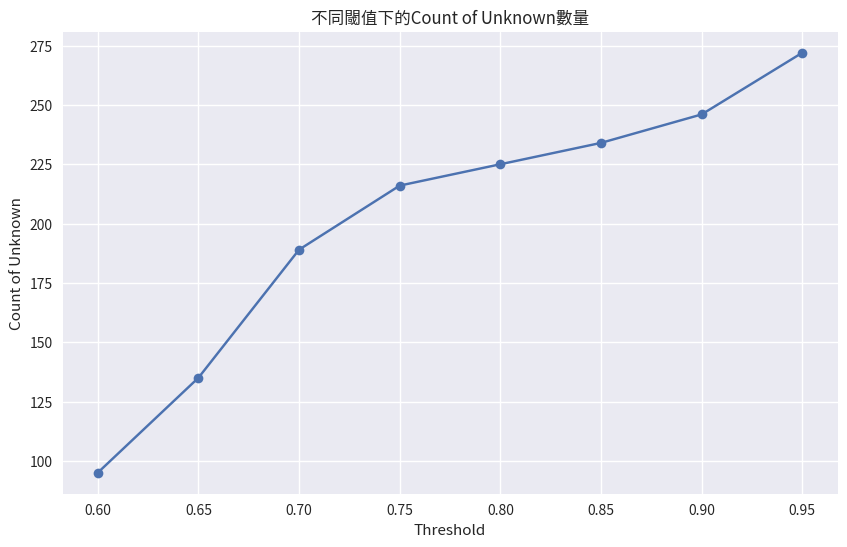

predict_label閥值設定為: 0.85 有 234 筆資料屬於unknown
Testing k = 1
K-means Iteration: 0
K-means Iteration: 1
Testing k = 2
K-means Iteration: 0
K-means Iteration: 1
K-means Iteration: 2
K-means Iteration: 3
Testing k = 3
K-means Iteration: 0
K-means Iteration: 1
K-means Iteration: 2
K-means Iteration: 3
K-means Iteration: 4
K-means Iteration: 5
Testing k = 4
K-means Iteration: 0
K-means Iteration: 1
K-means Iteration: 2
K-means Iteration: 3
K-means Iteration: 4
K-means Iteration: 5
K-means Iteration: 6
K-means Iteration: 7
K-means Iteration: 8
K-means Iteration: 9
K-means Iteration: 10
Testing k = 5
K-means Iteration: 0
K-means Iteration: 1
K-means Iteration: 2
K-means Iteration: 3
K-means Iteration: 4
K-means Iteration: 5
K-means Iteration: 6
K-means Iteration: 7
K-means Iteration: 8
K-means Iteration: 9
Testing k = 6
K-means Iteration: 0
K-means Iteration: 1
K-means Iteration: 2
K-means Iteration: 3
K-means Iteration: 4
K-means Iteration: 5
K-means Iteration: 6
K-means Iteration: 7
K-means It

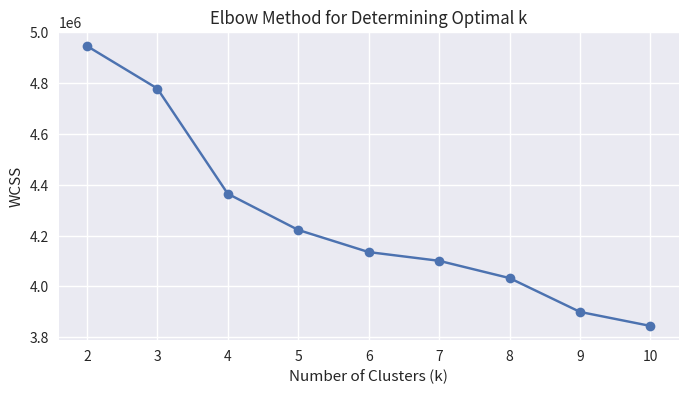

K-means Iteration: 0
K-means Iteration: 1
K-means Iteration: 2
K-means Iteration: 3
K-means Iteration: 4
K-means Iteration: 5
K-means Iteration: 6
K-means Iteration: 7
K-means Iteration: 8
K-means Iteration: 9
accuracy 0.536144578313253


In [15]:
# RandomOverSampler 資料
train_path = "dataset/gene expression cancer RNA-Seq Data Set/resampled_train_data_ADASYN.csv"
train_label_path = "dataset/gene expression cancer RNA-Seq Data Set/resampled_train_label_ADASYN.csv"
test_path = "dataset/gene expression cancer RNA-Seq Data Set/test_data.csv"
test_label_path = "dataset/gene expression cancer RNA-Seq Data Set/test_label.csv"

# 讀取資料集
train_data = pd.read_csv(train_path)
train_label = pd.read_csv(train_label_path)
test_data = pd.read_csv(test_path)
test_label = pd.read_csv(test_label_path)

test_data = test_data.drop(columns="id")
test_label = test_label.drop(columns="id")

# 資料前處理
train_data = data_preprocessing(train_data)
# 丟 dataframe 進去
random_forest(train_data, train_label, test_data, test_label)